# **Import all needed libraries**

In [0]:
import numpy as np
import pickle
from scipy.integrate import cumtrapz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import keras
from keras.models import Sequential
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import keras.backend.tensorflow_backend as tfback
from sklearn import preprocessing
import tensorflow as tf

def _get_available_gpus():  
  if tfback._LOCAL_DEVICES is None:  
      devices = tf.config.list_logical_devices()  
      tfback._LOCAL_DEVICES = [x.name for x in devices]  
  return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]
tfback._get_available_gpus = _get_available_gpus
 

Using TensorFlow backend.


In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# ***Download The Dataset And Extract it***
 




In [0]:
!wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
!tar xjvf RML2016.10b.tar.bz2

--2020-04-21 12:19:50--  http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
Resolving opendata.deepsig.io (opendata.deepsig.io)... 52.14.91.165
Connecting to opendata.deepsig.io (opendata.deepsig.io)|52.14.91.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1245608913 (1.2G) [application/x-bzip2]
Saving to: ‘RML2016.10b.tar.bz2’

RML2016.10b.tar.bz2 100%[===================>]   1.16G  11.0MB/s    in 79s     

2020-04-21 12:21:09 (15.0 MB/s) - ‘RML2016.10b.tar.bz2’ saved [1245608913/1245608913]

RML2016.10b.dat
LICENSE.TXT


# ***Deserialize/Unpickle The Dataset to be in a python compatible format***

In [0]:
with open("RML2016.10b.dat", 'rb') as f:
    Data = pickle.load(f, encoding="latin1") 

> Data is a dictionary that has tuples as keys and matrices as values





# ***Splitting the dataset into samples and their corresponding labels***



> X is 1,200,000 x 2 x 128 



In [0]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Data.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Data[(mod,snr)])
        for i in range(Data[(mod,snr)].shape[0]):  lbl.append((mod,snr))

X = np.vstack(X)
X = np.asarray(X)
X = np.reshape(X, (1200000,256))

scaler = StandardScaler()
X = scaler.fit_transform(X)

lbl = np.asarray(lbl) 



---



---





# ***Create new features***

In [0]:
X_deriv = []
for x in X:
  X_deriv.append(np.gradient(x))

X_int = []
for x in X:
  X_int.append(cumtrapz(x, initial=0))

X_combined = []
for x,x_d,x_i in zip(X,X_deriv,X_int):
  X_combined.append(np.concatenate((x, x_d, x_i), axis=0))

X_deriv = np.asarray(X_deriv)
X_int = np.asarray(X_int)
X_combined = np.asarray(X_combined)




---





---



# ***Splitting Data into training and test sets***

In [0]:

X_train, X_test, y_train, y_test = train_test_split(X, lbl, test_size=0.3, random_state=0)
X_deriv_train, X_deriv_test, y_deriv_train, y_deriv_test = train_test_split(X_deriv, lbl, test_size=0.3, random_state=0)
X_int_train, X_int_test, y_int_train, y_int_test = train_test_split(X_int, lbl, test_size=0.3, random_state=0)
X_combined_train, X_combined_test, y_combined_train, y_combined_test = train_test_split(X_combined, lbl, test_size=0.3, random_state=0)

del X_deriv
del X_int
del X_combined 

train = [X_train, X_deriv_train, X_int_train, X_combined_train]
test = [X_test, X_deriv_test, X_int_test, X_combined_test ]
lbl_train = [y_train, y_deriv_train, y_int_train, y_combined_train]
lbl_test = [y_test, y_deriv_test, y_int_test, y_combined_test]
  
 



---



---



# **Baseline Classifier**

In [0]:
y_mods_train = np.asarray(y_train)[:,0]
y_snr_train = np.asarray(y_train)[:,1]
y_mods_test = np.asarray(y_test)[:,0]
y_snr_test = np.asarray(y_test)[:,1]



> **Logistic Regression Classifier**



SNR =  -20
  Accuracy =  0.10433769691590859
SNR =  -18
  Accuracy =  0.0983295156153975
SNR =  -16
  Accuracy =  0.10084693476919625
SNR =  -14
  Accuracy =  0.10824197228560298
SNR =  -12
  Accuracy =  0.11329429150019156
SNR =  -10
  Accuracy =  0.14329523278505715
SNR =  -8
  Accuracy =  0.1714740948299544
SNR =  -6
  Accuracy =  0.1816216815385468
SNR =  -4
  Accuracy =  0.1813581002168956
SNR =  -2
  Accuracy =  0.18338488731771985
SNR =  0
  Accuracy =  0.17041002152199106
SNR =  2
  Accuracy =  0.1802660753880266
SNR =  4
  Accuracy =  0.1803480499132673
SNR =  6
  Accuracy =  0.17770849571317227
SNR =  8
  Accuracy =  0.17767514328640588
SNR =  10
  Accuracy =  0.18778305534077103
SNR =  12
  Accuracy =  0.17906886410299094
SNR =  14
  Accuracy =  0.18119610570236439
SNR =  16
  Accuracy =  0.17680916457110926
SNR =  18
  Accuracy =  0.17696028799640004


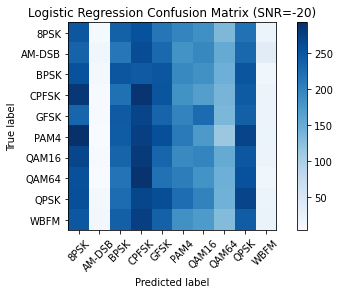

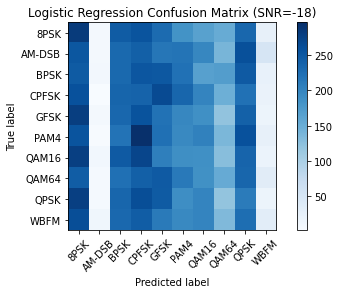

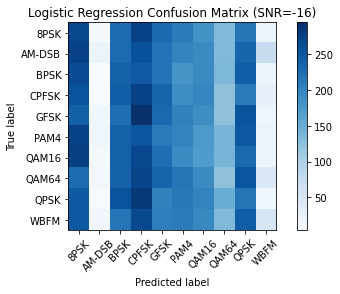

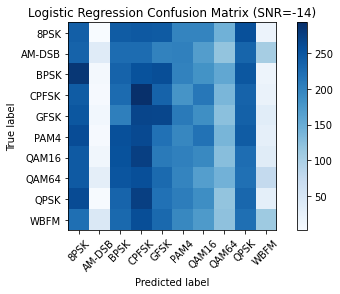

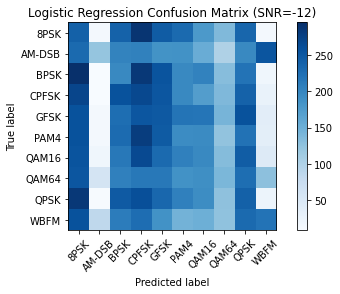

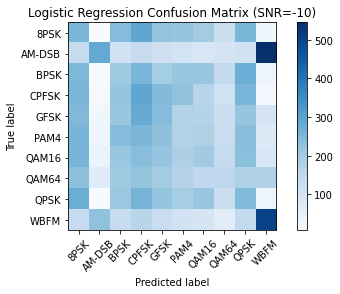

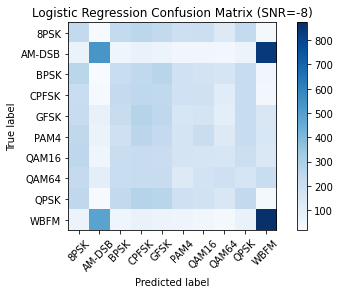

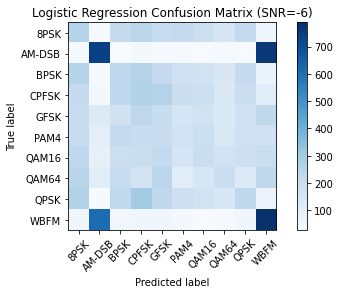

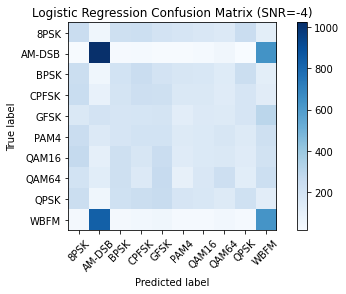

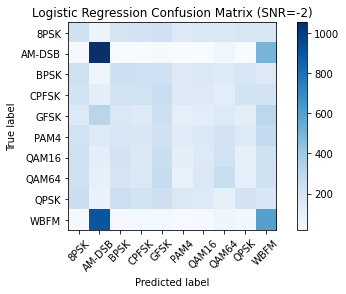

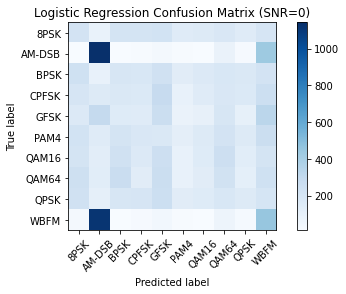

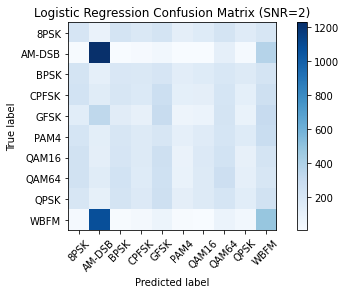

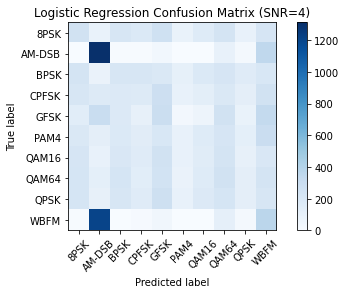

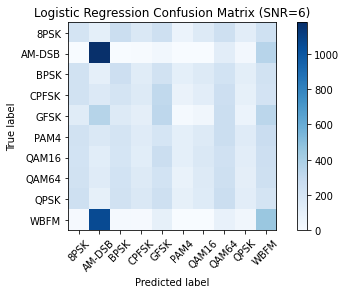

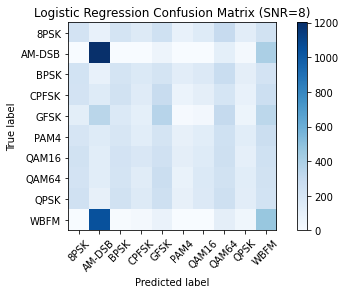

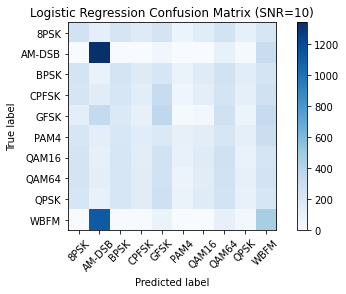

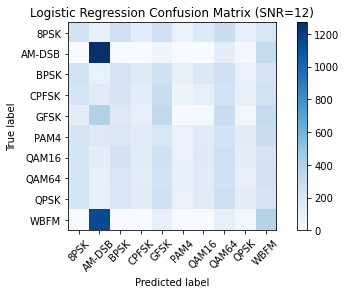

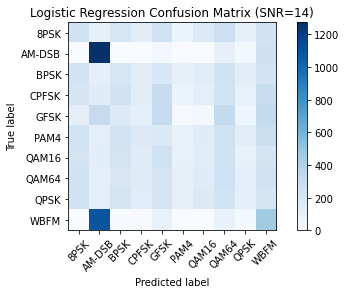

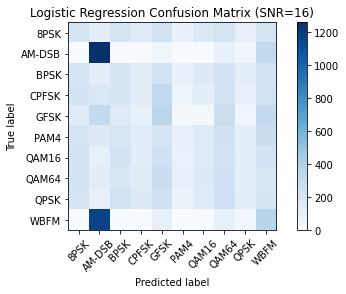

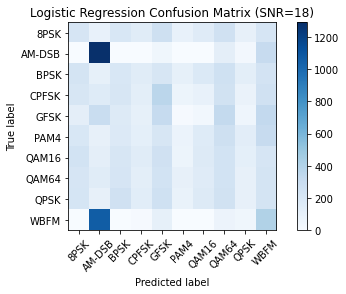

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, lbl, test_size=0.3, random_state=0)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_mods_train)

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_test[np.where(y_snr_test == str(snr))]
    test_Y_i = y_mods_test[np.where(y_snr_test == str(snr))]     
    y_pred = model.predict(test_X_i)

    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)
    conf = confusion_matrix(test_Y_i, y_pred)
    plt.figure()
    plot_confusion_matrix(conf, labels=mods, title="Logistic Regression Confusion Matrix (SNR=%d)"%(snr))

Text(0.5, 1.0, 'Logistic Regression Classification Accuracy')

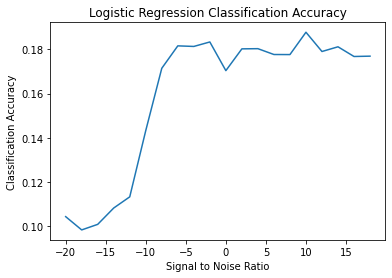

In [0]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Logistic Regression Classification Accuracy")



> **Decision Tree**



SNR =  -20
  Accuracy =  0.10228533392500555
SNR =  -18
  Accuracy =  0.10106709872059892
SNR =  -16
  Accuracy =  0.10151999551292837
SNR =  -14
  Accuracy =  0.10512549390617174
SNR =  -12
  Accuracy =  0.10710962727820043
SNR =  -10
  Accuracy =  0.1115137998327293
SNR =  -8
  Accuracy =  0.12372946541398824
SNR =  -6
  Accuracy =  0.15385468048550685
SNR =  -4
  Accuracy =  0.1870863689449975
SNR =  -2
  Accuracy =  0.22983870967741934
SNR =  0
  Accuracy =  0.28585618895204457
SNR =  2
  Accuracy =  0.3457871396895787
SNR =  4
  Accuracy =  0.4197302892955067
SNR =  6
  Accuracy =  0.487473555283376
SNR =  8
  Accuracy =  0.5202270324411552
SNR =  10
  Accuracy =  0.5433557936595603
SNR =  12
  Accuracy =  0.5570723045335997
SNR =  14
  Accuracy =  0.564172461752434
SNR =  16
  Accuracy =  0.5706063146130204
SNR =  18
  Accuracy =  0.5675554055574306


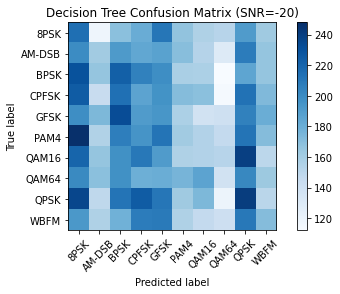

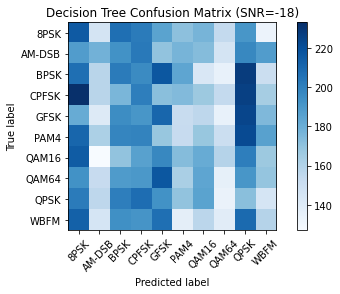

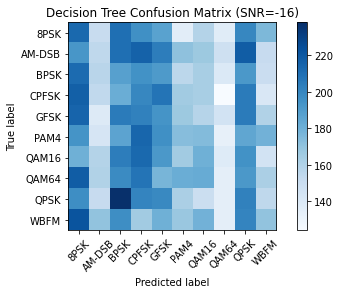

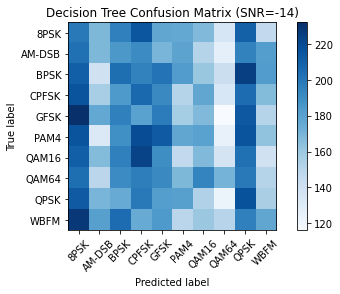

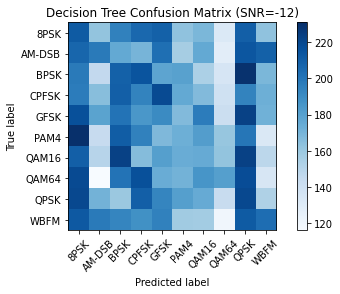

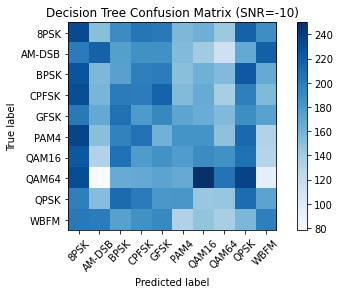

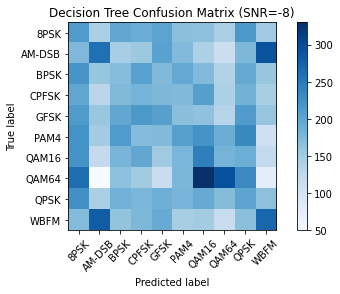

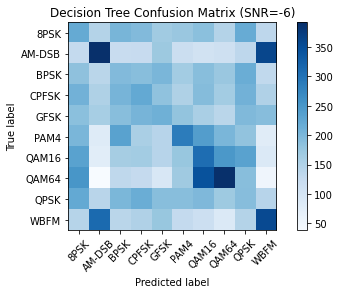

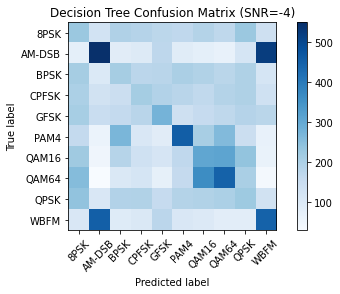

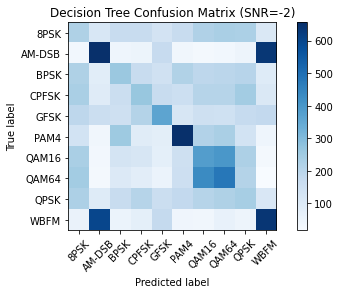

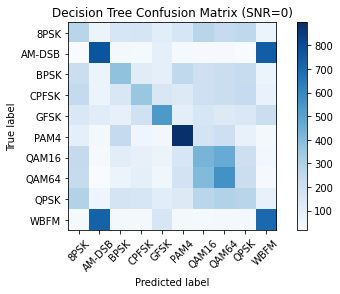

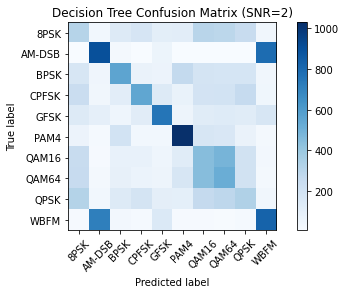

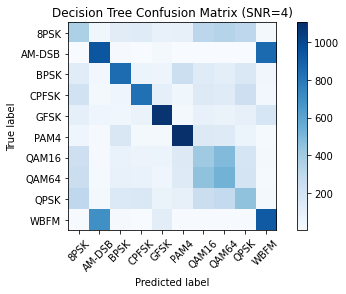

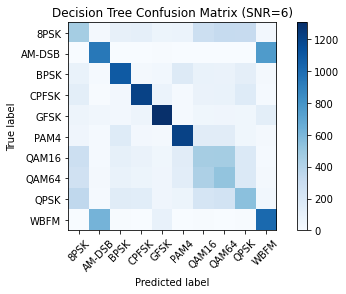

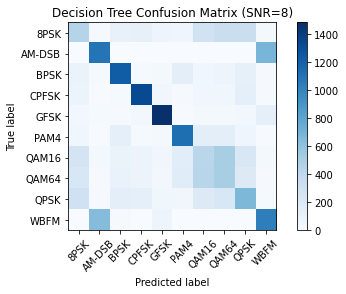

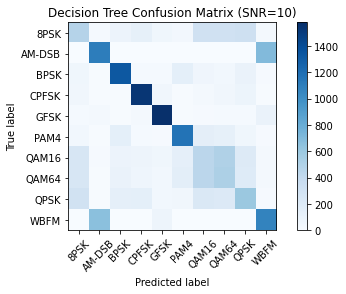

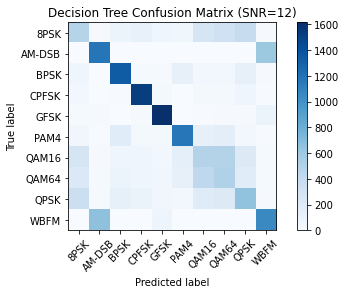

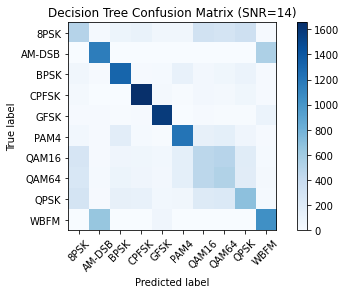

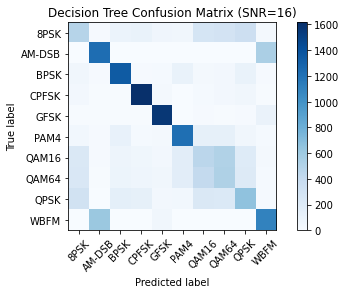

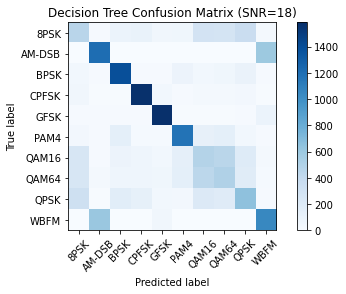

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, lbl, test_size=0.3, random_state=0)
model = DecisionTreeClassifier().fit(X_train,y_mods_train)
y_pred = model.predict(X_test)

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_test[np.where(y_snr_test == str(snr))]
    test_Y_i = y_mods_test[np.where(y_snr_test == str(snr))]   
    y_pred = model.predict(test_X_i)

    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)
    conf = confusion_matrix(test_Y_i, y_pred)
    plt.figure()
    plot_confusion_matrix(conf, labels=mods, title="Decision Tree Confusion Matrix (SNR=%d)"%(snr))  

Text(0.5, 1.0, 'Decision Trees Classification Accuracy')

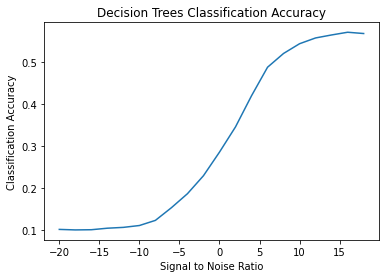

In [0]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Decision Trees Classification Accuracy")



> **Random Forest**



SNR =  -20
  Accuracy =  0.10089860217439539
SNR =  -18
  Accuracy =  0.10173752723615845
SNR =  -16
  Accuracy =  0.10252958662852656
SNR =  -14
  Accuracy =  0.10790806388780678
SNR =  -12
  Accuracy =  0.12495210990093591
SNR =  -10
  Accuracy =  0.1499860607750209
SNR =  -8
  Accuracy =  0.2026262293280589
SNR =  -6
  Accuracy =  0.2725156570415119
SNR =  -4
  Accuracy =  0.34275068127467884
SNR =  -2
  Accuracy =  0.40797613787008397
SNR =  0
  Accuracy =  0.5110645107885878
SNR =  2
  Accuracy =  0.6243348115299335
SNR =  4
  Accuracy =  0.6749482401656315
SNR =  6
  Accuracy =  0.7062131165794455
SNR =  8
  Accuracy =  0.7173779978854822
SNR =  10
  Accuracy =  0.7325748370705844
SNR =  12
  Accuracy =  0.7289273625215027
SNR =  14
  Accuracy =  0.7319054242002782
SNR =  16
  Accuracy =  0.730203967588712
SNR =  18
  Accuracy =  0.73827202159973


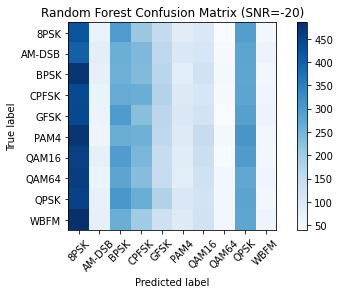

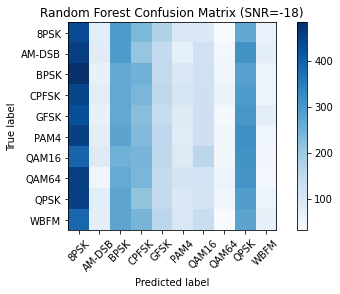

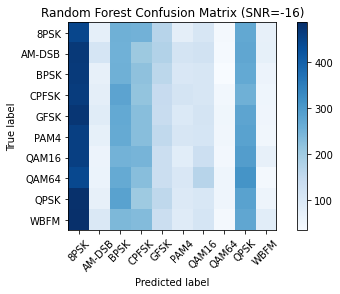

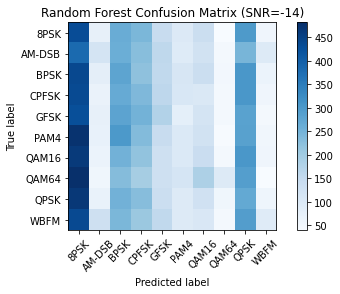

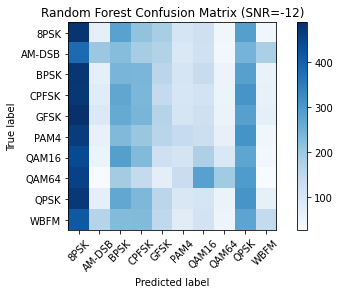

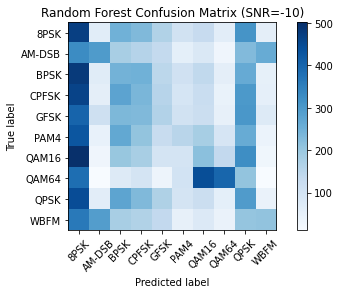

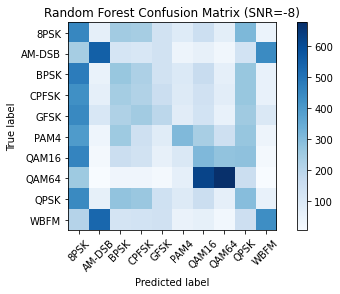

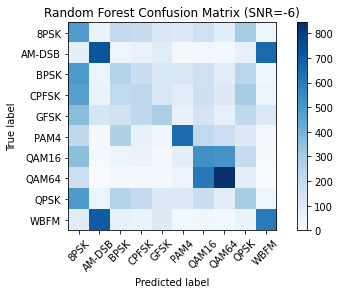

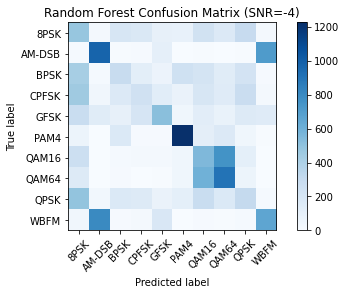

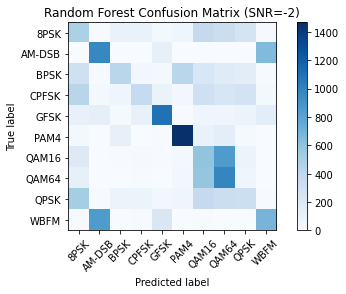

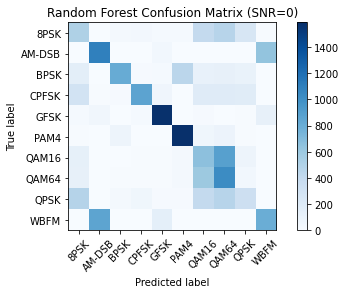

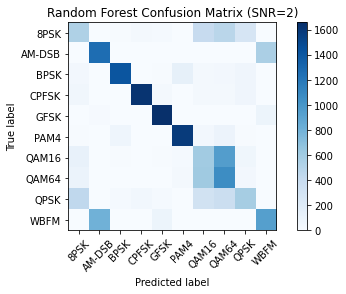

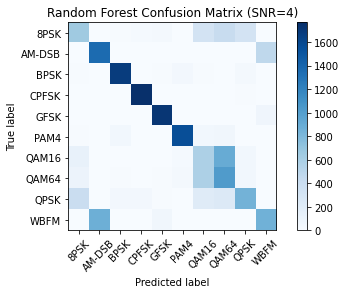

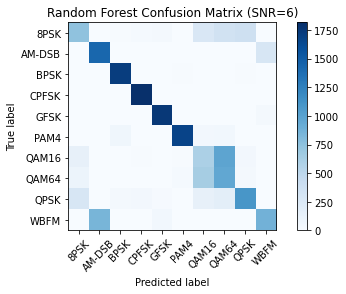

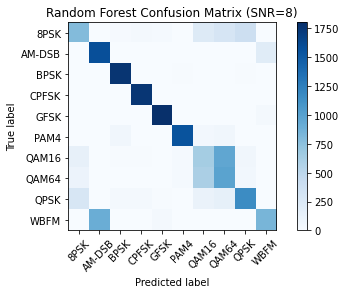

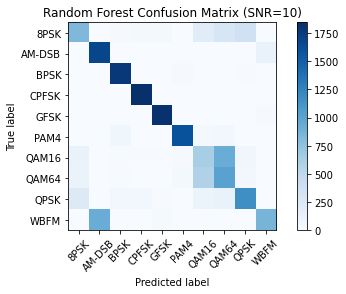

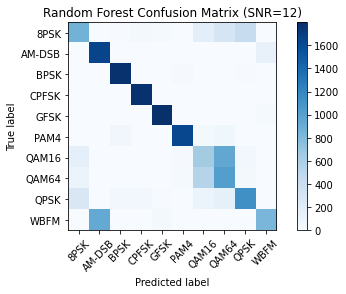

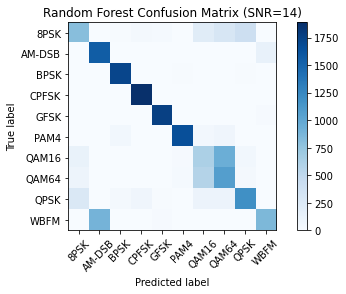

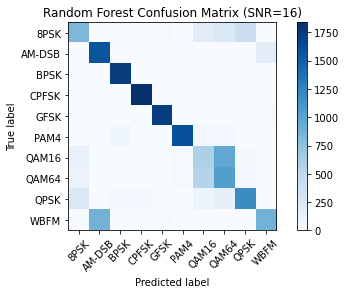

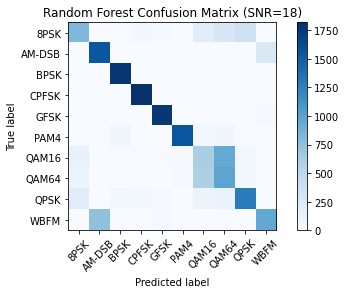

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, lbl, test_size=0.3, random_state=0)
model = RandomForestClassifier().fit(X_train,y_mods_train)
y_pred = model.predict(X_test)

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_test[np.where(y_snr_test == str(snr))]
    test_Y_i = y_mods_test[np.where(y_snr_test == str(snr))]   
    y_pred = model.predict(test_X_i)

    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)
    conf = confusion_matrix(test_Y_i, y_pred)
    plt.figure()
    plot_confusion_matrix(conf, labels=mods, title="Random Forest
     Confusion Matrix (SNR=%d)"%(snr))  

Text(0.5, 1.0, 'Random Forests Classification Accuracy')

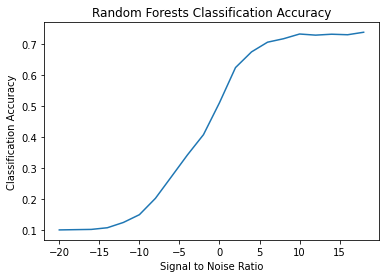

In [0]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Random Forests Classification Accuracy")



> **Fully Connected Dense Layer**



In [0]:
X_train = np.reshape(X_train, (X_train.shape[0],2,128))
X_test = np.reshape(X_test, (X_test.shape[0],2,128))

X_train, X_test, y_train, y_test = train_test_split(X, lbl, test_size=0.3, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.05, random_state=0)

y_mods_train = np.asarray(y_train)[:,0]
y_snr_train = np.asarray(y_train)[:,1]
y_mods_valid = np.asarray(y_valid)[:,0]
y_snr_valid = np.asarray(y_valid)[:,1]
y_mods_test = np.asarray(y_test)[:,0]
y_snr_test = np.asarray(y_test)[:,1]

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_mods_train = lb.fit_transform(y_mods_train)
# y_snr_train = lb.fit_transform(y_snr_train)
y_mods_test = lb.fit_transform(y_mods_test)
# y_snr_test = lb.fit_transform(y_snr_test)
y_mods_valid = lb.fit_transform(y_mods_valid)

In [0]:
in_shp = list(X_train.shape[1:])
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(Flatten())
model.add(Dense(10,activation='softmax', name="dense2", kernel_initializer="he_normal"))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.build(X_train.shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 256)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense2 (Dense)               (None, 10)                2570      
Total params: 2,570
Trainable params: 2,570
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(X_train,
    y_mods_train,
    batch_size=1024,
    nb_epoch=100,
    verbose=2,
    validation_data=(X_valid, y_mods_valid),
    callbacks = [
         keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ]) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 798000 samples, validate on 42000 samples
Epoch 1/100
 - 2s - loss: 2.2481 - val_loss: 2.1627
Epoch 2/100
 - 2s - loss: 2.1628 - val_loss: 2.1611
Epoch 3/100
 - 2s - loss: 2.1628 - val_loss: 2.1619
Epoch 4/100
 - 2s - loss: 2.1629 - val_loss: 2.1615
Epoch 5/100
 - 2s - loss: 2.1630 - val_loss: 2.1612
Epoch 6/100
 - 2s - loss: 2.1628 - val_loss: 2.1628
Epoch 7/100
 - 2s - loss: 2.1629 - val_loss: 2.1617


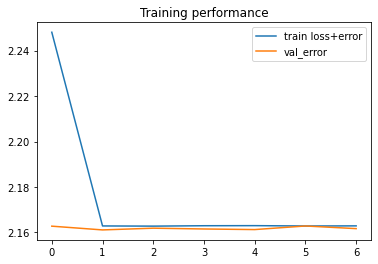

In [0]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

  Accuracy =  0.10461504326603062
  Accuracy =  0.1002849321191128
  Accuracy =  0.10583880195187616
  Accuracy =  0.11085758806833992
  Accuracy =  0.11696130479995621
  Accuracy =  0.14390855868413716
  Accuracy =  0.17317729795066206
  Accuracy =  0.18561214875575016
  Accuracy =  0.18480618430565596
  Accuracy =  0.18294299602297834
  Accuracy =  0.1752110810661663
  Accuracy =  0.1837028824833703
  Accuracy =  0.1809635722679201
  Accuracy =  0.17659503396058346
  Accuracy =  0.17828724055422626
  Accuracy =  0.18375124268198387
  Accuracy =  0.1795682814494201
  Accuracy =  0.1788595271210014
  Accuracy =  0.17725621682034087
  Accuracy =  0.18146023174710316


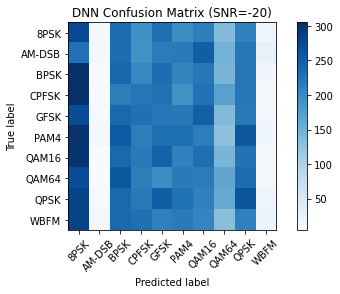

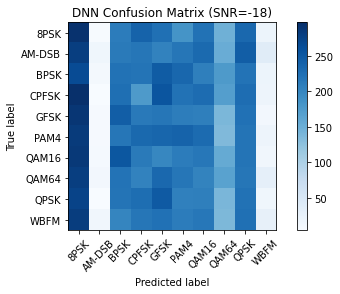

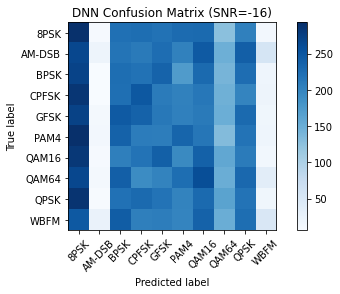

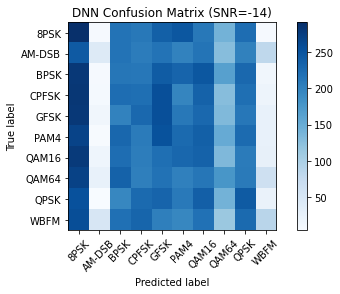

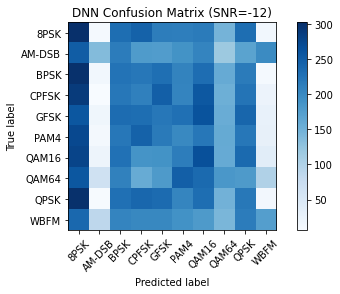

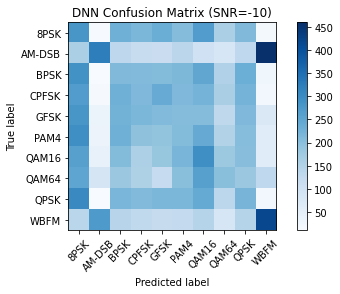

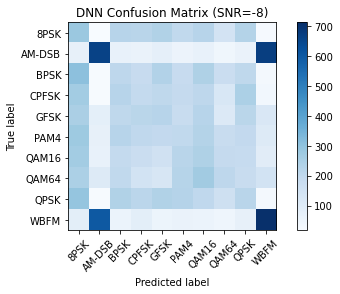

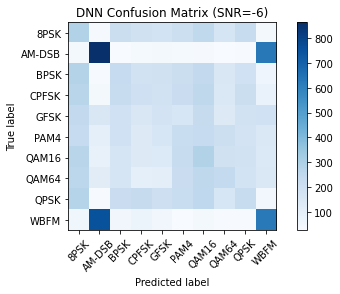

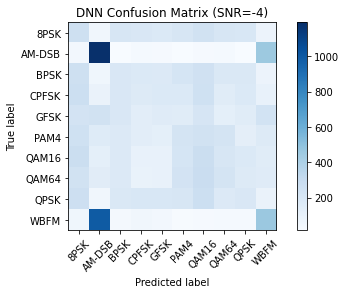

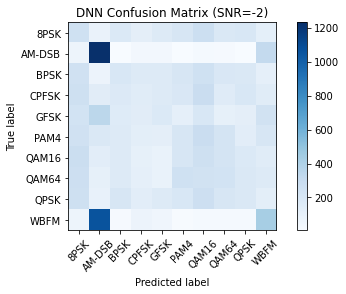

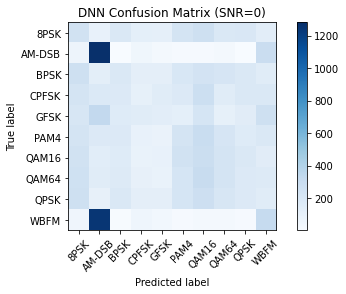

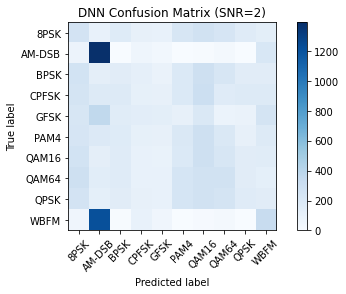

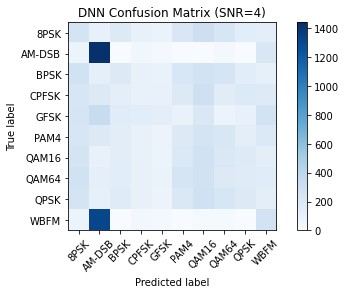

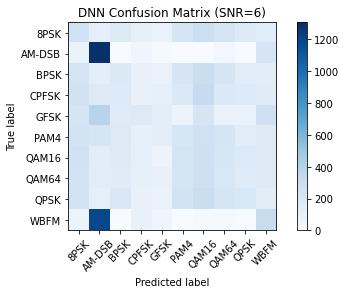

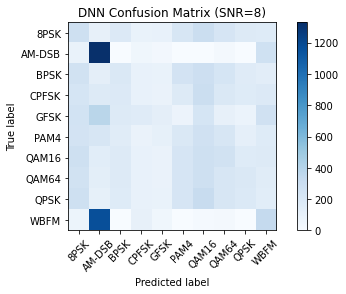

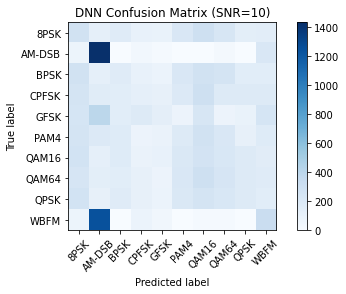

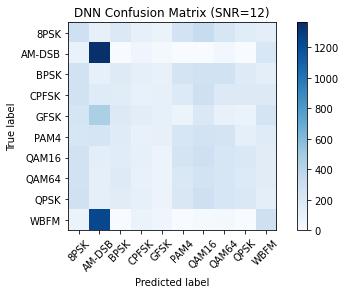

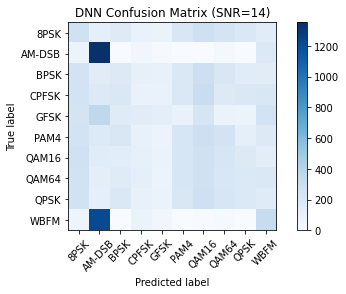

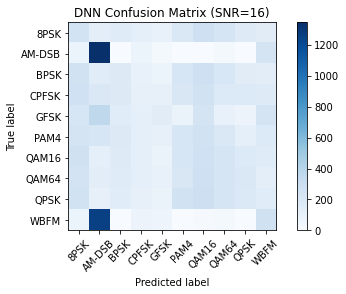

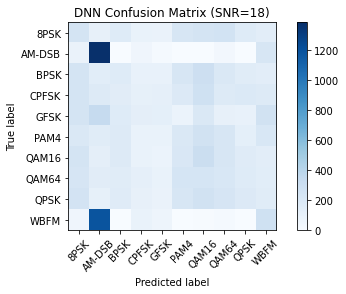

In [0]:
# Plot confusion matrix
acc = []
for snr in snrs:
  test_X_i = X_test[np.where(y_snr_test == str(snr))]
  test_Y_i = y_mods_test[np.where(y_snr_test == str(snr))] 
  y_pred = model.predict(test_X_i, batch_size=batch_size)
  
  test_Y_i = np.argmax(test_Y_i, axis=1)
  y_pred = np.argmax(y_pred, axis=1)

  accuracy = accuracy_score(test_Y_i, y_pred)
  acc.append(accuracy)
  print("  Accuracy = ",accuracy)

  conf = confusion_matrix(test_Y_i, y_pred)
  plt.figure()
  plot_confusion_matrix(conf, labels=mods, title="DNN Confusion Matrix (SNR=%d)"%(snr))

Text(0.5, 1.0, 'Dense layer NN Classification Accuracy')

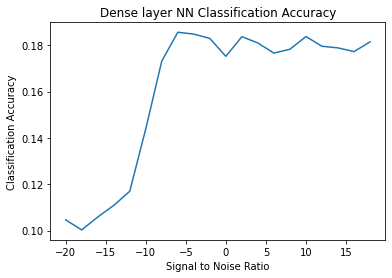

In [0]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")



---





---







# **CNN Model**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, lbl, test_size=0.3, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.05, random_state=0)

X_train = np.reshape(X_train, (X_train.shape[0],2,128))
X_test = np.reshape(X_test, (X_test.shape[0],2,128))

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.05, random_state=0)

y_mods_train = np.asarray(y_train)[:,0]
y_snr_train = np.asarray(y_train)[:,1]
y_mods_valid = np.asarray(y_valid)[:,0]
y_snr_valid = np.asarray(y_valid)[:,1]
y_mods_test = np.asarray(y_test)[:,0]
y_snr_test = np.asarray(y_test)[:,1]

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_mods_train = lb.fit_transform(y_mods_train)
# y_snr_train = lb.fit_transform(y_snr_train)
y_mods_test = lb.fit_transform(y_mods_test)
# y_snr_test = lb.fit_transform(y_snr_test)
y_mods_valid = lb.fit_transform(y_mods_valid)

In [0]:
in_shp = list(X_train.shape[1:])
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(64, (1, 3), activation="relu", name="conv1",  padding="valid",data_format = 'channels_first', kernel_initializer="glorot_uniform"))
model.add(Dropout(0.5))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(16, (2, 3), activation="relu", name="conv2", padding="valid",data_format = 'channels_first',  kernel_initializer="glorot_uniform"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation="relu", name="dense1", kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax', name="dense2", kernel_initializer="he_normal"))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.build(X_train.shape)                          
model.summary()
 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 6, 126)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 126)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 10, 126)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 9, 124)        6160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 9, 124)       

In [0]:
history = model.fit(X_train,
    y_mods_train,
    batch_size=1024,
    nb_epoch=100,
    verbose=2,
    validation_data=(X_valid, y_mods_valid),
    callbacks = [
         keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ]) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 758100 samples, validate on 39900 samples
Epoch 1/100
 - 117s - loss: 1.6972 - val_loss: 1.4186
Epoch 2/100
 - 110s - loss: 1.4605 - val_loss: 1.2952
Epoch 3/100
 - 110s - loss: 1.3757 - val_loss: 1.2380
Epoch 4/100
 - 110s - loss: 1.3497 - val_loss: 1.2181
Epoch 5/100
 - 110s - loss: 1.3371 - val_loss: 1.2142
Epoch 6/100
 - 110s - loss: 1.3283 - val_loss: 1.1896
Epoch 7/100
 - 110s - loss: 1.3194 - val_loss: 1.1888
Epoch 8/100
 - 110s - loss: 1.3119 - val_loss: 1.1887
Epoch 9/100


KeyboardInterrupt: ignored

In [0]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [0]:
# Plot confusion matrix
acc = []
for snr in snrs:
  test_X_i = X_test[np.where(y_snr_test == str(snr))]
  test_Y_i = y_mods_test[np.where(y_snr_test == str(snr))] 
  y_pred = model.predict(test_X_i, batch_size=batch_size)
  
  test_Y_i = np.argmax(test_Y_i, axis=1)
  y_pred = np.argmax(y_pred, axis=1)

  accuracy = accuracy_score(test_Y_i, y_pred)
  acc.append(accuracy)
  print("  Accuracy = ",accuracy)

  conf = confusion_matrix(test_Y_i, y_pred)
  plt.figure()
  plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix (SNR=%d)"%(snr))

In [0]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN Classification Accuracy")